<a href="https://colab.research.google.com/github/flxhrdyn/CNN-Mango-Leaf-Disease-Classification/blob/main/CNN_Mango_Leaf_Disease_Classification_Ver1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16

# Download Dataset

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1li3lNOB_Hx2LDjhaT79GCF3JRcbSegnT/view?usp=drive_link

Downloading...
From (original): https://drive.google.com/uc?id=1li3lNOB_Hx2LDjhaT79GCF3JRcbSegnT
From (redirected): https://drive.google.com/uc?id=1li3lNOB_Hx2LDjhaT79GCF3JRcbSegnT&confirm=t&uuid=f408c2d7-e4f4-447f-a0ee-815ad2c0cc89
To: /content/mango_leaf_disease_dataset_pi.zip
100% 48.6M/48.6M [00:03<00:00, 14.1MB/s]


# Extract Dataset

In [ ]:
# extract the dataset
zip_ref = zipfile.ZipFile('/content/mango_leaf_disease_dataset_pi.zip', 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

# Shuffle & Resize Data

In [ ]:
DATASET_DIR = './tmp/mango_leaf_disease_dataset_pi'
IMG_SIZE = 224
BATCH_SIZE = 32

# shuffle and resize data
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    shuffle = True,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

# print image classes
img_class = dataset.class_names
print(f'Classes: {img_class}')

Found 2000 files belonging to 4 classes.
Classes: ['anthracnose', 'bacterial_canker', 'healthy', 'powdery_mildew']


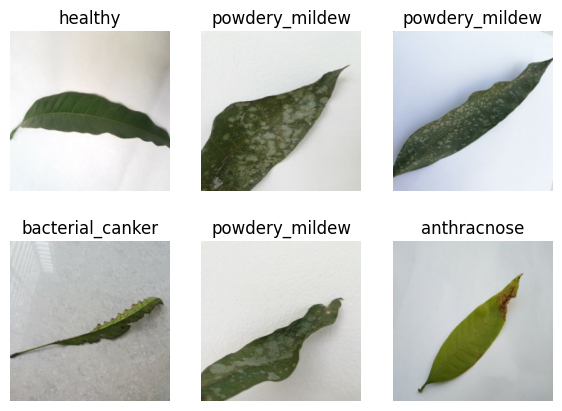

In [ ]:
# Take sample image
plt.figure(figsize=(7, 5))
for img, label in dataset.take(1):
  for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(img[i].numpy().astype('uint8'))
    plt.title(img_class[label[i]]);
    plt.axis('off')

# Data Splitting

In [ ]:
# create a function for splitting dataset
def split_dataset(ds, train_split_size, val_split_size, test_split_size):
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=2000)

  # Calculate train, validation, and test set size
  train_set_size = int(len(ds) * train_split_size)
  val_set_size = int(len(ds) * val_split_size)
  test_set_size = int(len(ds) * test_split_size)

  # Split the dataset
  train_set = ds.take(train_set_size)
  validation_set = ds.skip(train_set_size).take(val_set_size)
  test_set = ds.skip(train_set_size).skip(val_set_size)

  return train_set, validation_set, test_set

In [ ]:
# splitting dataset to 80% train, 10% validation, and 10% testing
train_set, validation_set, test_set = split_dataset(ds=dataset, train_split_size=0.8,
                                                    val_split_size=0.1, test_split_size=0.1)

print(f'dataset size : {len(dataset)*BATCH_SIZE}')
print(f'training set size : {len(train_set)*BATCH_SIZE}')
print(f'validation set size : {len(validation_set)*BATCH_SIZE}')
print(f'test set size : {len(test_set)*BATCH_SIZE}')

dataset size : 2016
training set size : 1600
validation set size : 192
test set size : 224


# Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1.0/255.0),
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)])

# CNN Model 1 (4 Layers)

## 1. Model Architecture

In [ ]:
model_1 = models.Sequential([
    # Applying data augmentation
    data_augmentation,
    # Convolution and Max pooling layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (4, 4), activation='relu', padding='valid'),
    layers.MaxPooling2D(3, 3),
    # Flatten layer
    layers.Flatten(),
    # Fully Connected layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])
model_1.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

## 2. Compiling Model

In [ ]:
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

## 3. Training Model

In [ ]:
%%time
EPOCHS = 20
history_model_1 = model_1.fit(train_set,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data = validation_set,
                      verbose = 2)

Epoch 1/20
50/50 - 16s - loss: 1.3788 - accuracy: 0.2715 - val_loss: 1.3576 - val_accuracy: 0.3021 - 16s/epoch - 325ms/step
Epoch 2/20
50/50 - 6s - loss: 1.3021 - accuracy: 0.4268 - val_loss: 1.1575 - val_accuracy: 0.5521 - 6s/epoch - 123ms/step
Epoch 3/20
50/50 - 9s - loss: 1.0768 - accuracy: 0.5347 - val_loss: 0.9209 - val_accuracy: 0.6979 - 9s/epoch - 177ms/step
Epoch 4/20
50/50 - 6s - loss: 0.9226 - accuracy: 0.6181 - val_loss: 0.8597 - val_accuracy: 0.6823 - 6s/epoch - 118ms/step
Epoch 5/20
50/50 - 6s - loss: 0.8181 - accuracy: 0.6540 - val_loss: 0.6010 - val_accuracy: 0.8542 - 6s/epoch - 128ms/step
Epoch 6/20
50/50 - 6s - loss: 0.6888 - accuracy: 0.7386 - val_loss: 0.5888 - val_accuracy: 0.7656 - 6s/epoch - 113ms/step
Epoch 7/20
50/50 - 6s - loss: 0.5993 - accuracy: 0.7638 - val_loss: 0.4354 - val_accuracy: 0.8750 - 6s/epoch - 125ms/step
Epoch 8/20
50/50 - 7s - loss: 0.5036 - accuracy: 0.8220 - val_loss: 0.4831 - val_accuracy: 0.8646 - 7s/epoch - 146ms/step
Epoch 9/20
50/50 - 6s 

## 4. Plot Model's Accuracy and Loss

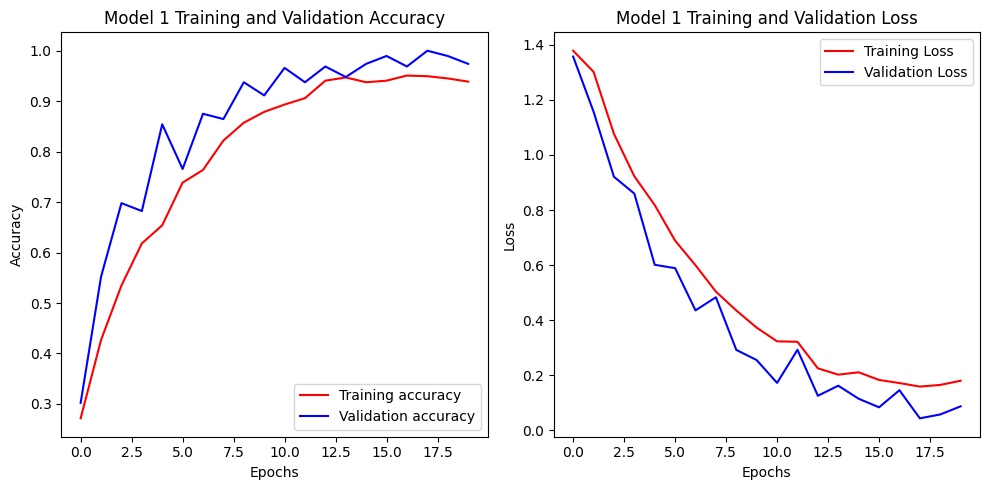

In [ ]:
# Plot the results
acc = history_model_1.history['accuracy']
val_acc = history_model_1.history['val_accuracy']
loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']
epochs = range(len(acc))

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first subplot
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Model 1 Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss on the second subplot
ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
ax2.set_title('Model 1 Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Saving the Model

In [ ]:
model_1.save('tmp/model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# CNN Model 2 (6 Layer)

## 1. Model Architecture

In [ ]:
model_2 = models.Sequential([
    # Applying data augmentation
    data_augmentation,
    # Convolution and Max pooling layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # Flatten layer
    layers.Flatten(),
    # Fully Connected layer
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model_2.build(input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 111, 111, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 52, 52, 64)         

## 2. Compiling Model

In [ ]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

## 3. Training Model

In [ ]:
%%time
EPOCHS = 20
history_model_2 = model_2.fit(train_set,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data = validation_set,
                      verbose = 2)

Epoch 1/20
50/50 - 12s - loss: 1.3792 - accuracy: 0.3226 - val_loss: 1.3584 - val_accuracy: 0.2865 - 12s/epoch - 242ms/step
Epoch 2/20
50/50 - 6s - loss: 1.2939 - accuracy: 0.3725 - val_loss: 1.1121 - val_accuracy: 0.5573 - 6s/epoch - 124ms/step
Epoch 3/20
50/50 - 6s - loss: 1.0279 - accuracy: 0.5406 - val_loss: 0.8753 - val_accuracy: 0.5938 - 6s/epoch - 127ms/step
Epoch 4/20
50/50 - 6s - loss: 0.8320 - accuracy: 0.6282 - val_loss: 0.6931 - val_accuracy: 0.7240 - 6s/epoch - 121ms/step
Epoch 5/20
50/50 - 7s - loss: 0.7614 - accuracy: 0.6326 - val_loss: 0.7025 - val_accuracy: 0.7031 - 7s/epoch - 139ms/step
Epoch 6/20
50/50 - 6s - loss: 0.6559 - accuracy: 0.7027 - val_loss: 0.6214 - val_accuracy: 0.7031 - 6s/epoch - 124ms/step
Epoch 7/20
50/50 - 7s - loss: 0.5730 - accuracy: 0.7298 - val_loss: 0.5593 - val_accuracy: 0.7812 - 7s/epoch - 135ms/step
Epoch 8/20
50/50 - 7s - loss: 0.5375 - accuracy: 0.7481 - val_loss: 0.4087 - val_accuracy: 0.8385 - 7s/epoch - 136ms/step
Epoch 9/20
50/50 - 6s 

## 4. Plot Model's Accuracy and Loss


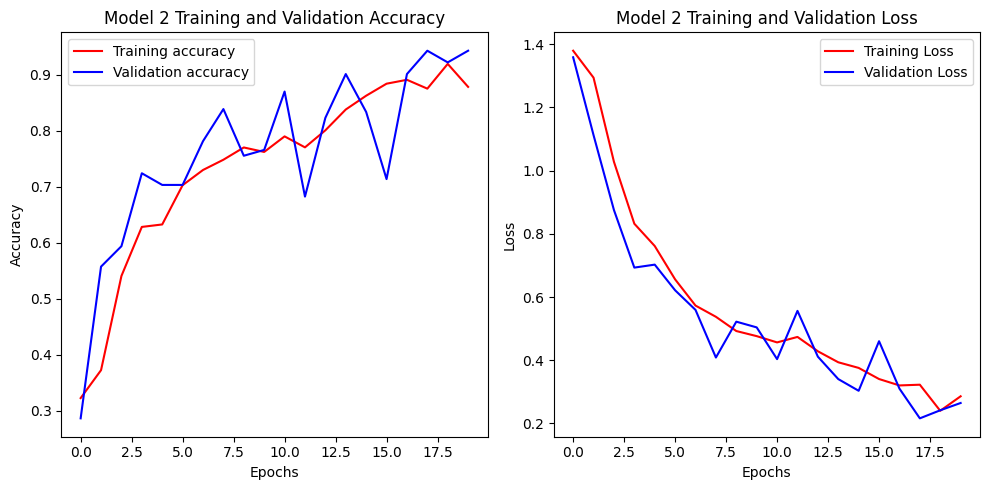

In [ ]:
# Plot the results
acc = history_model_2.history['accuracy']
val_acc = history_model_2.history['val_accuracy']
loss = history_model_2.history['loss']
val_loss = history_model_2.history['val_loss']
epochs = range(len(acc))

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first subplot
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Model 2 Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss on the second subplot
ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
ax2.set_title('Model 2 Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Saving the Model

In [ ]:
model_2.save('tmp/model_2.h5')

# CNN Model 3 (VGG16 Architecture)

## 1. Model Architecture

In [ ]:
# Load the pre-trained model
VGG16_model_3 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                include_top=False,
                weights='imagenet')

# Freeze the layers
for layer in VGG16_model_3.layers:
  layer.trainable = False

# Model architecture summary
VGG16_model_3.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
last_layer = VGG16_model_3.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_layer_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


## 2. Add Fully Connected Layers

In [ ]:
# Define the new model including data augmentation
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Apply data augmentation

# Pass the augmented data through VGG16
x = VGG16_model_3(x, training=False)

# Flatten layer
x = layers.Flatten()(x)

# Fully connected layer
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(4, activation='softmax')(x)

# Define the complete model
model_3 = Model(inputs, outputs)

# Model architecture summary
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028  

In [ ]:
# # Flatten layer
# x = layers.Flatten()(last_layer_output)

# # Fully connected layer
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(4, activation='softmax')(x)

# # Defining the model
# model_3 = Model(VGG16_model_3.input, x)

# # Model architecture summary
# model_3.summary()

## 3. Compile Model

In [ ]:
model_3.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

## 4. Training Model

In [ ]:
%%time
EPOCHS = 20
history_model_3 = model_3.fit(train_set,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      validation_data = validation_set,
                      verbose = 2)

Epoch 1/20
50/50 - 24s - loss: 0.6152 - accuracy: 0.7639 - val_loss: 0.2220 - val_accuracy: 0.9375 - 24s/epoch - 485ms/step
Epoch 2/20
50/50 - 12s - loss: 0.2064 - accuracy: 0.9425 - val_loss: 0.1133 - val_accuracy: 0.9844 - 12s/epoch - 243ms/step
Epoch 3/20
50/50 - 13s - loss: 0.1511 - accuracy: 0.9527 - val_loss: 0.0997 - val_accuracy: 0.9659 - 13s/epoch - 250ms/step
Epoch 4/20
50/50 - 11s - loss: 0.0909 - accuracy: 0.9762 - val_loss: 0.0551 - val_accuracy: 0.9948 - 11s/epoch - 217ms/step
Epoch 5/20
50/50 - 11s - loss: 0.0777 - accuracy: 0.9804 - val_loss: 0.0421 - val_accuracy: 0.9844 - 11s/epoch - 222ms/step
Epoch 6/20
50/50 - 11s - loss: 0.0605 - accuracy: 0.9887 - val_loss: 0.0620 - val_accuracy: 0.9792 - 11s/epoch - 223ms/step
Epoch 7/20
50/50 - 11s - loss: 0.0569 - accuracy: 0.9886 - val_loss: 0.0313 - val_accuracy: 1.0000 - 11s/epoch - 230ms/step
Epoch 8/20
50/50 - 11s - loss: 0.0429 - accuracy: 0.9905 - val_loss: 0.0421 - val_accuracy: 0.9792 - 11s/epoch - 219ms/step
Epoch 9/

## 5. Plot Model's Accuracy and Loss

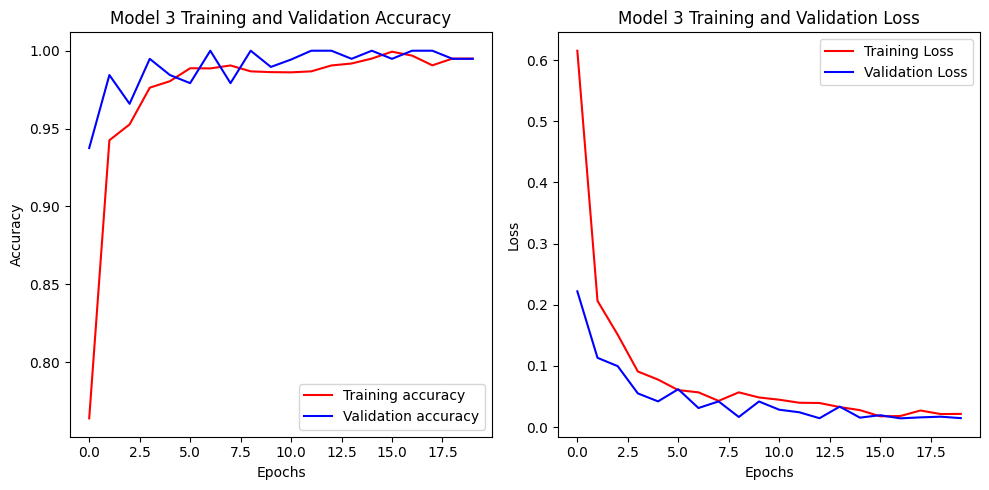

In [ ]:
# Plot the results
acc = history_model_3.history['accuracy']
val_acc = history_model_3.history['val_accuracy']
loss = history_model_3.history['loss']
val_loss = history_model_3.history['val_loss']
epochs = range(len(acc))

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first subplot
ax1.plot(epochs, acc, 'r', label='Training accuracy')
ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax1.set_title('Model 3 Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss on the second subplot
ax2.plot(epochs, loss, 'r', label='Training Loss')
ax2.plot(epochs, val_loss, 'b', label='Validation Loss')
ax2.set_title('Model 3 Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

## 6. Saving the Model

In [ ]:
model_3.save('tmp/model_3.h5')

# Testing Model 1

In [ ]:
saved_model_1 = tf.keras.models.load_model('tmp/model_1.h5')
saved_model_2 = tf.keras.models.load_model('tmp/model_2.h5')
saved_model_3 = tf.keras.models.load_model('tmp/model_3.h5')

## 1. Model 1 Evaluation

In [ ]:
# Evaluate the model 1 on the test data
print('Evaluate model 1 accuracy on test data')
model_1_results = saved_model_1.evaluate(test_set, batch_size=BATCH_SIZE)
print('test loss, test acc:', model_1_results)

Evaluate model 1 accuracy on test data
7/7 [==============================] - 3s 20ms/step - loss: 0.0463 - accuracy: 0.9821
test loss, test acc: [0.04634122923016548, 0.9821428656578064]


## 2. Model 1 Confusion Matrix

7/7 [==============================] - 0s 17ms/step


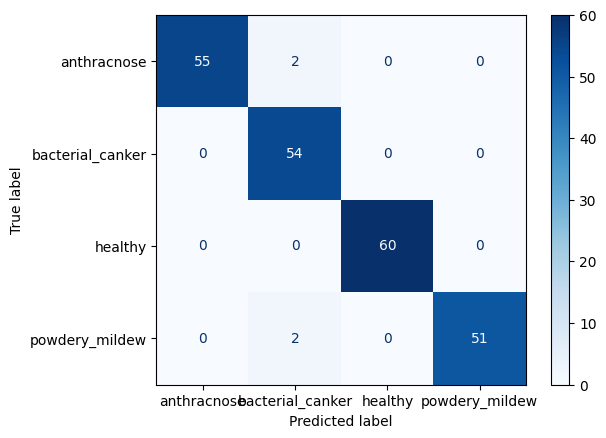

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_images = []
val_labels = []

for images, labels in test_set:
    val_images.append(images)
    val_labels.append(labels)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

predictions = saved_model_1.predict(val_images)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=img_class)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 3. Model 1 Image Predictions

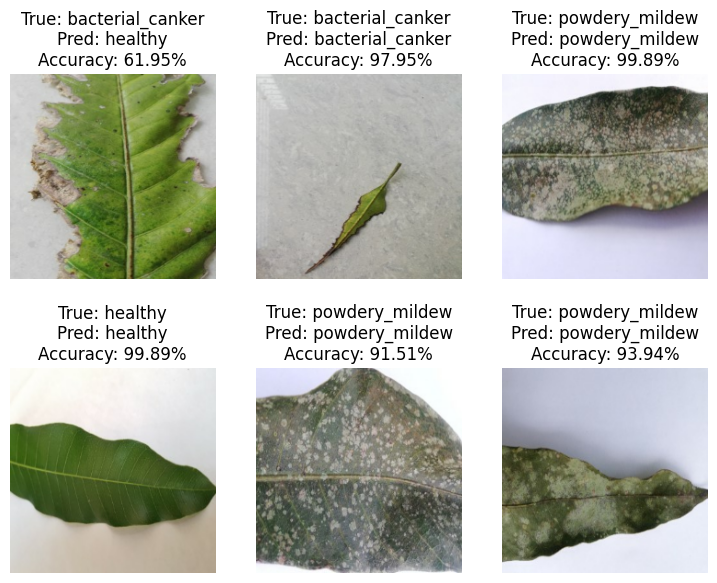

In [ ]:
# Testing the image predictions
plt.figure(figsize=(9, 7))

for img, label in test_set.take(1):
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        first_img = img[i].numpy().astype('uint8')
        first_label = label[i].numpy()

        # Predict the label for the image
        prediction = saved_model_1.predict(tf.expand_dims(img[i], axis=0), verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        predicted_class = img_class[predicted_label]

        true_label = img_class[first_label]
        accuracy = prediction[0, np.argmax(prediction[0])] * 100

        plt.imshow(first_img)  # Display the image
        plt.axis('off')
        plt.title(f'True: {true_label}\nPred: {predicted_class}\nAccuracy: {accuracy:.2f}%')

plt.show()

## 4. Model 1 Wrong Image Predictions

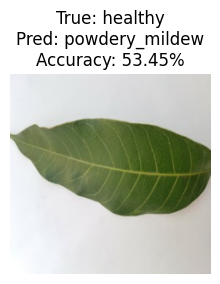

In [ ]:
# Prepare a figure to display the wrong predictions
plt.figure(figsize=(15, 5))
count = 1  # Counter for subplot positioning

for img, label in test_set.take(1):
    for i in range(len(img)):
        first_img = img[i].numpy().astype('uint8')
        first_label = label[i].numpy()

        # Predict the label for the image
        prediction = saved_model_1.predict(tf.expand_dims(img[i], axis=0), verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        predicted_class = img_class[predicted_label]
        true_label = img_class[first_label]
        accuracy = prediction[0, np.argmax(prediction[0])] * 100

        # Show only the wrong predictions
        if true_label != predicted_class:
            plt.subplot(1, 5, count)
            plt.imshow(first_img)  # Display the image
            plt.axis('off')
            plt.title(f'True: {true_label}\nPred: {predicted_class}\nAccuracy: {accuracy:.2f}%')
            count += 1

        if count > 5:  # Limit to showing 5 images
            break

    if count > 5:  # Break outer loop if already showing 5 images
        break
plt.show()

# Testing Model 2

## 1. Model 2 Evaluation

In [ ]:
# Evaluate the model 2 on the test data
print('Evaluate model 2 accuracy on test data')
model_2_results = saved_model_2.evaluate(test_set, batch_size=BATCH_SIZE)
print('test loss, test acc:', model_2_results)

Evaluate model 2 accuracy on test data
7/7 [==============================] - 2s 21ms/step - loss: 0.2530 - accuracy: 0.9375
test loss, test acc: [0.253020316362381, 0.9375]


## 2. Model 2 Confusion Matrix

7/7 [==============================] - 0s 23ms/step


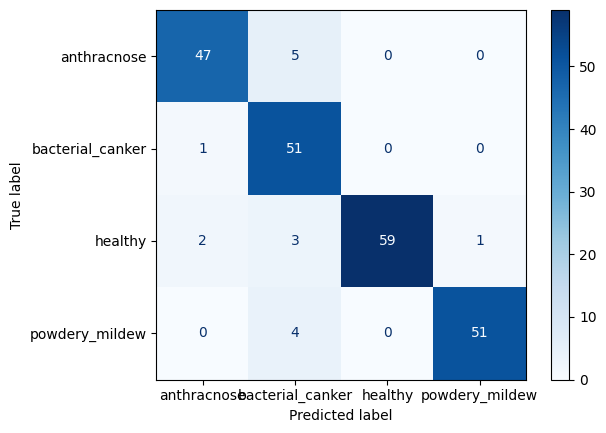

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_images = []
val_labels = []

for images, labels in test_set:
    val_images.append(images)
    val_labels.append(labels)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

predictions = saved_model_2.predict(val_images)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=img_class)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 3. Model 2 Image Predictions

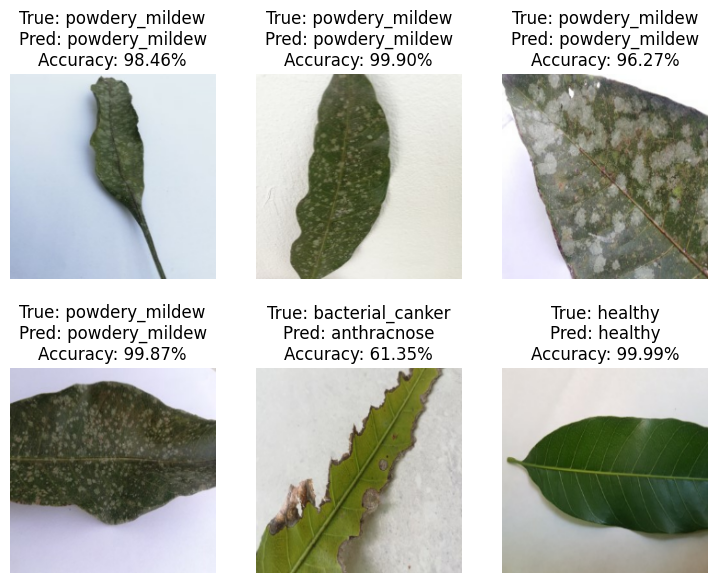

In [ ]:
# Testing the image predictions
plt.figure(figsize=(9, 7))

for img, label in test_set.take(1):
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        first_img = img[i].numpy().astype('uint8')
        first_label = label[i].numpy()

        # Predict the label for the image
        prediction = saved_model_2.predict(tf.expand_dims(img[i], axis=0), verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        predicted_class = img_class[predicted_label]

        true_label = img_class[first_label]
        accuracy = prediction[0, np.argmax(prediction[0])] * 100

        plt.imshow(first_img)  # Display the image
        plt.axis('off')
        plt.title(f'True: {true_label}\nPred: {predicted_class}\nAccuracy: {accuracy:.2f}%')

plt.show()

## 4. Model 2 Wrong Image Predictions

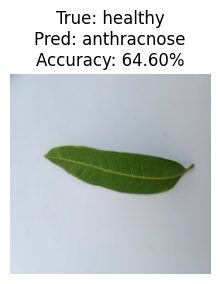

In [ ]:
# Prepare a figure to display the wrong predictions
plt.figure(figsize=(15, 5))
count = 1  # Counter for subplot positioning

for img, label in test_set.take(1):
    for i in range(len(img)):
        first_img = img[i].numpy().astype('uint8')
        first_label = label[i].numpy()

        # Predict the label for the image
        prediction = saved_model_2.predict(tf.expand_dims(img[i], axis=0), verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        predicted_class = img_class[predicted_label]
        true_label = img_class[first_label]
        accuracy = prediction[0, np.argmax(prediction[0])] * 100

        # Show only the wrong predictions
        if true_label != predicted_class:
            plt.subplot(1, 5, count)
            plt.imshow(first_img)  # Display the image
            plt.axis('off')
            plt.title(f'True: {true_label}\nPred: {predicted_class}\nAccuracy: {accuracy:.2f}%')
            count += 1

        if count > 5:  # Limit to showing 5 images
            break

    if count > 5:  # Break outer loop if already showing 5 images
        break
plt.show()

# Testing Model 3

## 1. Model 3 Evaluation

In [ ]:
# Evaluate the model 3 on the test data
print('Evaluate model 3 accuracy on test data')
model_3_results = saved_model_3.evaluate(test_set, batch_size=BATCH_SIZE)
print('test loss, test acc:', model_3_results)

Evaluate model 3 accuracy on test data
7/7 [==============================] - 141s 18s/step - loss: 0.0205 - accuracy: 0.9904
test loss, test acc: [0.020507005974650383, 0.9903846383094788]


## 2. Model 3 Confusion Matrix

7/7 [==============================] - 1s 128ms/step


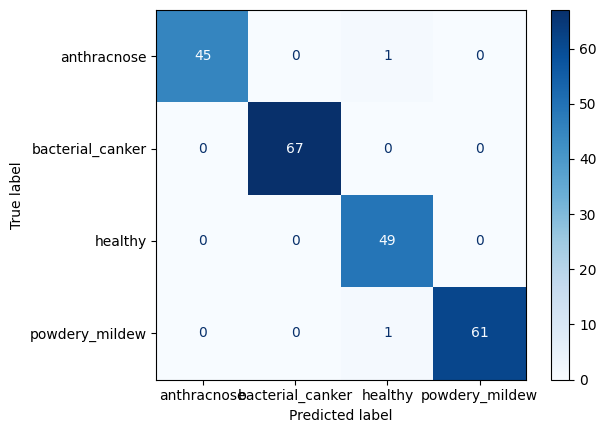

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

val_images = []
val_labels = []

for images, labels in test_set:
    val_images.append(images)
    val_labels.append(labels)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

predictions = saved_model_3.predict(val_images)
predicted_labels = np.argmax(predictions, axis=-1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=img_class)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 3. Model 3 Image Predictions

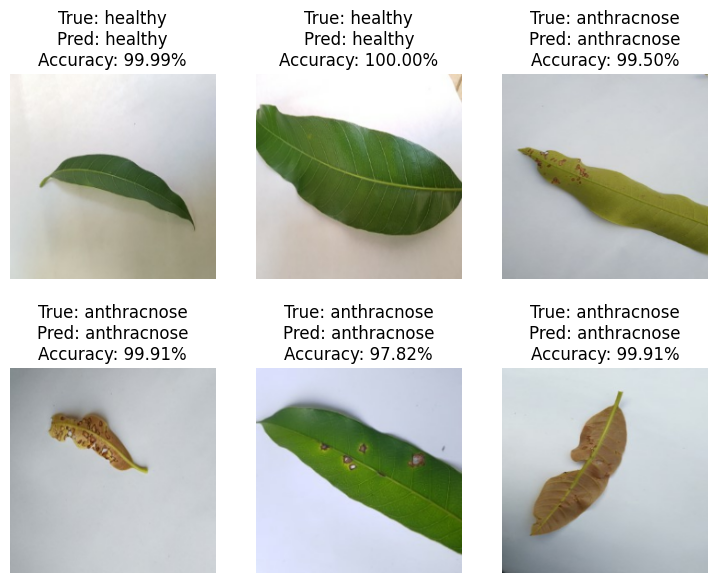

In [ ]:
# Testing the image predictions
plt.figure(figsize=(9, 7))

for img, label in test_set.take(1):
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        first_img = img[i].numpy().astype('uint8')
        first_label = label[i].numpy()

        # Predict the label for the image
        prediction = saved_model_3.predict(tf.expand_dims(img[i], axis=0), verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        predicted_class = img_class[predicted_label]

        true_label = img_class[first_label]
        accuracy = prediction[0, np.argmax(prediction[0])] * 100

        plt.imshow(first_img)  # Display the image
        plt.axis('off')
        plt.title(f'True: {true_label}\nPred: {predicted_class}\nAccuracy: {accuracy:.2f}%')

plt.show()

## 4. Model 3 Wrong Image Predictions

In [ ]:
# Prepare a figure to display the wrong predictions
plt.figure(figsize=(15, 5))
count = 1  # Counter for subplot positioning

for img, label in test_set.take(1):
    for i in range(len(img)):
        first_img = img[i].numpy().astype('uint8')
        first_label = label[i].numpy()

        # Predict the label for the image
        prediction = saved_model_3.predict(tf.expand_dims(img[i], axis=0), verbose=0)
        predicted_label = np.argmax(prediction, axis=-1)[0]
        predicted_class = img_class[predicted_label]
        true_label = img_class[first_label]
        accuracy = prediction[0, np.argmax(prediction[0])] * 100

        # Show only the wrong predictions
        if true_label != predicted_class:
            plt.subplot(1, 5, count)
            plt.imshow(first_img)  # Display the image
            plt.axis('off')
            plt.title(f'True: {true_label}\nPred: {predicted_class}\nAccuracy: {accuracy:.2f}%')
            count += 1

        if count > 5:  # Limit to showing 5 images
            break

    if count > 5:  # Break outer loop if already showing 5 images
        break
plt.show()

<Figure size 1500x500 with 0 Axes>

7/7 [==============================] - 3s 125ms/step - loss: 0.0274 - accuracy: 0.9911


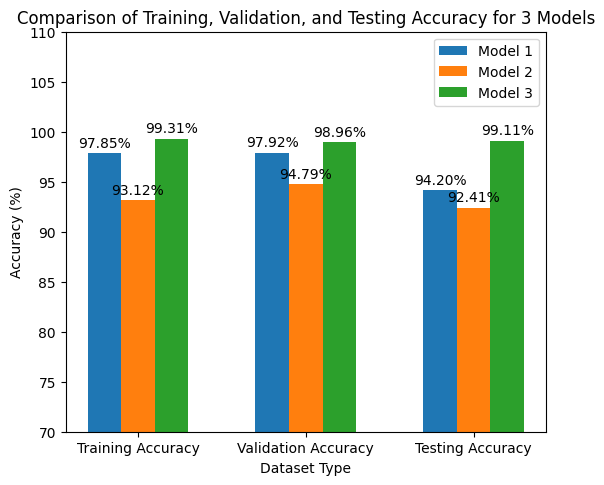

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume models are already loaded: saved_model_1, saved_model_2, saved_model_3
models = [saved_model_1, saved_model_2, saved_model_3]

# Store accuracies for each dataset type
train_accuracies = []
val_accuracies = []
test_accuracies = []

for model in models:
    train_acc = model.evaluate(train_set, verbose=1)[1] * 100  # Convert to percentage
    val_acc = model.evaluate(validation_set, verbose=1)[1] * 100  # Convert to percentage
    test_acc = model.evaluate(test_set, verbose=1)[1] * 100  # Convert to percentage

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

# Plotting the bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 5))  # Adjusted figure size

# Adjust bar positions
rects1 = ax.bar(x - width, [train_accuracies[0], val_accuracies[0], test_accuracies[0]], width, label='Model 1')
rects2 = ax.bar(x, [train_accuracies[1], val_accuracies[1], test_accuracies[1]], width, label='Model 2')
rects3 = ax.bar(x + width, [train_accuracies[2], val_accuracies[2], test_accuracies[2]], width, label='Model 3')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Dataset Type')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparison of Training, Validation, and Testing Accuracy for 3 Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(70, 110)  # Adjusted y-axis range to better visualize accuracies
ax.legend()

# Function to add labels to the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 2 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjusting layout to add space between plot and figure edges
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()